#### Study case: car's license plate detection + OCR

---
 **Main goal:** extract car's number from given image
 **Dataset:** https://makeml.app/datasets/cars-license-plates}
 **Technologies:** pytorch and other ml related libraries

##### Stage 1: import(install) all needed libraries, define constants.

In [1]:
# This tool is needed to download the dataset from g_disk.
!pip install gdown nebulgym xmltodict torchmetrics -q

# I suppose these libraries are installed
import time
import tqdm
import os
import gdown
import cv2
import torch
import random
import xmltodict
from PIL import Image
import numpy as np
import torchvision
import seaborn as sns
from torch import nn
from matplotlib import pyplot as plt
import torchvision.transforms as trfs
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from nebulgym.decorators.torch_decorators import accelerate_model, accelerate_dataset

/opt/conda/lib/python3.7/site-packages/nebulgym/training_learners/model_engines/ort_engine.py:15: UserWarning: No ONNXRuntime training library for pytorch has been detected. The ORT backend won't be used.
  "No ONNXRuntime training library for pytorch has been detected. "
/opt/conda/lib/python3.7/site-packages/nebulgym/training_learners/model_engines/rammer_engine.py:17: UserWarning: No valid Rammer installation found. Using the Rammer backend will result in an error.
  "No valid Rammer installation found. Using the Rammer backend "


In [2]:
# Make results reproducible
curr_seed = 21

random.seed(curr_seed)
np.random.seed(curr_seed)
torch.manual_seed(curr_seed)
torch.cuda.manual_seed(curr_seed)
torch.backends.cudnn.deterministic = True

In [3]:
# Constants cell
sns.set_theme('paper')
sns.set_style('whitegrid')

im_size = 320
n_classes = 2                 # license + background
split_factor = 0.12
pref_batch_size = 32
ssd_weights_path = None
train_q = True

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {dev}')

Using device: cuda


##### Stage 2: download the dataset & implement the torch.utils.data.Dataset

In [4]:
# Loads the dataset(zip format) and extracts content
dataset_path = './dataset'
output_path = f'{dataset_path}/dataset.zip'
dataset_location = 'https://drive.google.com/file/d/1JNxP_tVV8oVfdGij2gKBC-S04NizfGy4/view?usp=sharing'

if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)
    gdown.download(dataset_location, output_path, fuzzy = True)
    gdown.extractall(output_path, dataset_path)
    os.remove(output_path)

Downloading...
From: https://drive.google.com/uc?id=1JNxP_tVV8oVfdGij2gKBC-S04NizfGy4
To: /kaggle/working/dataset/dataset.zip
100%|██████████| 24.6M/24.6M [00:00<00:00, 269MB/s]


In [5]:
!ls dataset/'My dataset/'

README.dataset.txt  annotations  images


In [6]:
# Shape of bbox_list is [N,4]. b_boxes are in format [xmin, ymin, xmax, ymax]
def plot_detection(img, bbox_list, labels = ['Class 0'], title = 'Detection plot', b_color = 'orangered'):
    img = img.cpu()

    im_channels = img.size(0)
    if im_channels == 1 or im_channels == 3:
        img = img.permute(1, 2, 0)

    fig, ax = plt.subplots(1, 1, figsize = (8, 8))
    ax.set_title(title, size = 14)
    ax.imshow(img)

    for bbox, label in zip(bbox_list, labels):
        x_min, y_min, x_max, y_max = bbox
        ax.plot([x_min, x_min], [y_min, y_max], color = b_color)
        ax.plot([x_max, x_max], [y_min, y_max], color = b_color)
        ax.plot([x_min, x_max], [y_min, y_min], color = b_color)
        ax.plot([x_min, x_max], [y_max, y_max], color = b_color)
        ax.text(x_min - 3, y_min - 3, label, color = b_color, fontweight='bold', size = 12)

In [7]:
# Dataset of cars' license plates.
@accelerate_dataset() # "nebulgym provides cached dataset to speed up this process by caching data samples in memory"
class LicensePlateDataset(torch.utils.data.Dataset):

    _trf = trfs.Compose([
        trfs.ToTensor(),
    ])

    def __init__(self, path = './dataset/My dataset', dev = 'cpu'):
        self.dev = dev
        self.annotation_path = path + '/annotations'
        self.image_path      = path + '/images'
        assert os.path.exists(self.annotation_path) and os.path.exists(self.image_path), 'Dataset structure is incorrect'

        self.images_paths = os.listdir(self.image_path)
        self.annotations_paths = os.listdir(self.annotation_path)

    def __len__(self):
        return len(self.images_paths)

    # Returns bounding box as [xmin, ymin, xmax, ymax]
    def __getitem__(self, item):

        curr_annotation_path = self.annotation_path + '/' + self.annotations_paths[item]
        with open(curr_annotation_path, 'r') as annotation:
            annotation_content = annotation.read()
        anno = xmltodict.parse(annotation_content)

        # Grayscale + bilateralFilter
        curr_img_path = self.image_path + '/' + anno['annotation']['filename']
        img = cv2.imread(curr_img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.bilateralFilter(img, 11, 17, 17)
        prep_img = self._trf(img)

        all_bbox = []
        all_labels = []
        if 'object' not in anno['annotation']:
            return self.last_img, self.last_dt
        objects = anno['annotation']['object']

        if not isinstance(objects, list):
            all_bbox.append(LicensePlateDataset._bbox_scaler(objects['bndbox']))
            all_labels.append(1 if objects['name'] == 'license plate' else 0)
        else:
            for obj in objects:
                all_bbox.append(LicensePlateDataset._bbox_scaler(obj['bndbox']))
                all_labels.append(1 if obj['name'] == 'license plate' else 0)
        train_data = {
            'boxes': torch.Tensor(all_bbox).to(dev),
            'labels': torch.LongTensor(all_labels).to(dev),
        }

        self.last_img = prep_img
        self.last_dt  = train_data

        return prep_img, train_data

    # Scale in format (x_scale, y_scale)
    @staticmethod
    def _bbox_scaler(box_dict, scale = None):
        if scale is None:
            scale = (1, 1)
        x_scale, y_scale = scale
        out_list = []
        for k, v in zip(box_dict, box_dict.values()):
            out_list.append(int(v) / (x_scale if k[0] == 'x' else y_scale))
        
        x_min, x_max, y_min, y_max = out_list
        return [x_min, y_min, x_max, y_max]

torch.Size([1, 320, 320])


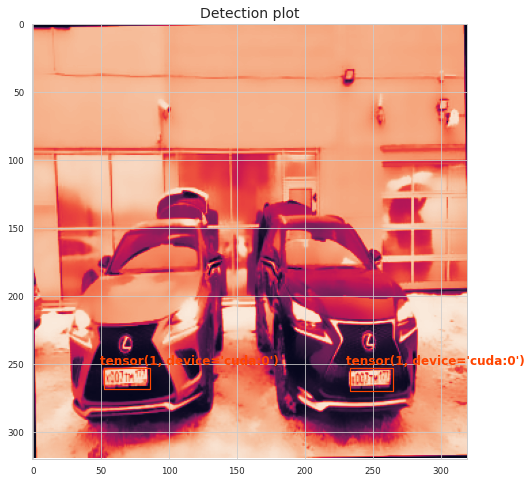

In [8]:
ds = LicensePlateDataset()
curr_img, t_data = ds[210]
print(curr_img.shape)
plot_detection(curr_img, t_data['boxes'].cpu(), labels = t_data['labels'])

In [9]:
test_count = round(len(ds) * split_factor)
train_count = len(ds) - test_count

ds_train, ds_test = torch.utils.data.random_split(
    ds, (train_count, test_count)
)
print(f'[+] ds_train: {train_count} | ds_test: {test_count}')

[+] ds_train: 1183 | ds_test: 161


In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

dl_train = torch.utils.data.DataLoader(
    ds_train, pref_batch_size,
    shuffle = True, collate_fn = collate_fn
)

dl_test = torch.utils.data.DataLoader(
    ds_test, pref_batch_size,
    shuffle = False, collate_fn = collate_fn, drop_last = True
)

##### Stage 3: Model creation & training.

In [11]:
# ANPR implementation: SSD + OCR model
import warnings
warnings.filterwarnings('ignore')

@accelerate_model()
class ANPRv1(nn.Module):
    def __init__(self, cl_count, ssd_weights_path = None):
        super(ANPRv1, self).__init__()

        # Detector, that suites my requests
        self.ssd_model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(num_classes = cl_count)
        if ssd_weights_path is not None and os.path.exists(ssd_weights_path):
            print('[+] Loading state of SSD model')
            self.ssd_model = torch.load(ssd_weights_path, map_location=torch.device('cpu'))

    # Gets image(s) as input, train_data on **train_mode**
    # returns: **inference** recognised text on plate or None; **train** SSD's losses and ...
    def forward(self, X, train_data = None):
        if train_data is not None:
            # Calculate
            self.ssd_model.train()
            reg_loss, clf_loss = self.ssd_model(X, train_data).values()
            return reg_loss, clf_loss

        else:
            self.ssd_model.eval()
            return self.ssd_model(X)

# Load model from torchhub
model = ANPRv1(n_classes)
model.to(dev)

ANPRv1(
  (ssd_model): SSD(
    (backbone): SSDLiteFeatureExtractorMobileNet(
      (features): Sequential(
        (0): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (2): Hardswish()
          )
          (1): InvertedResidual(
            (block): Sequential(
              (0): ConvNormActivation(
                (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
                (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
                (2): ReLU(inplace=True)
              )
              (1): ConvNormActivation(
                (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  

In [12]:
# Training function for my model
def model_train_v1(dl_tr, dl_vl, model: ANPRv1, optim, scheduler, epochs_count = 30, alpha = 0.8):
    t_bar = tqdm.tqdm(range(epochs_count))

    # Run for N epochs
    for epoch_n in t_bar:
        av_losses = 0.0
        map_scores = 0.0
        map_score = MeanAveragePrecision()

        # [Train]
        for X_batch, train_data_batch in dl_tr:
            # Switch the device
            start_time = time.time()
            X_batch = [t.to(dev) for t in X_batch]

            # Calculate loss
            reg_loss, clf_loss = model(X_batch, train_data_batch)
            ssd_loss = reg_loss + alpha * clf_loss

            # Backpropagation
            optim.zero_grad()
            ssd_loss.backward()
            optim.step()

            av_losses += ssd_loss.item()
            status = f'{(time.time() - start_time)}ms reg_loss: {reg_loss:.2f} | clf_loss: {clf_loss:.2f}'
            t_bar.set_description(status)

        scheduler.step()

        # [Evaluate]
        with torch.inference_mode():
            for X_batch, targets in dl_vl:
                # Switching the device... again...
                X_batch = [t.to(dev) for t in X_batch]

                # Calculate metrics
                predictions  = model(X_batch)
                map_score.update(predictions, targets)
                map_scores += map_score.compute()['map']


        # Update epoch's info
        epoch_status = f'[epoch: {epoch_n}] train_loss: {av_losses / len(dl_tr):.2f} | val_mAP: f{map_scores / len(dl_vl):.2f}'
        print(epoch_status)


if train_q:
    # Select some options
    optimizer = torch.optim.AdamW(model.parameters(), lr= 3e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)


    # Run training
    model_train_v1(dl_train, dl_test, model, optimizer, scheduler)

    # Save the model
    model.ssd_model.eval()
    torch.save(model.ssd_model, 'conceptB_ANPRv1.pt')

!nvidia-smi

0.28480005264282227ms reg_loss: 3.99 | clf_loss: 3.26:   3%|▎         | 1/30 [01:42<49:28, 102.35s/it]

[epoch: 0] train_loss: 8.77 | val_mAP: f0.00


0.2102034091949463ms reg_loss: 3.79 | clf_loss: 2.77:   7%|▋         | 2/30 [03:14<44:59, 96.42s/it]  

[epoch: 1] train_loss: 6.98 | val_mAP: f0.00


0.20995807647705078ms reg_loss: 4.26 | clf_loss: 2.70:  10%|█         | 3/30 [05:03<45:53, 101.99s/it]

[epoch: 2] train_loss: 6.05 | val_mAP: f0.00


0.21211576461791992ms reg_loss: 3.06 | clf_loss: 2.32:  13%|█▎        | 4/30 [06:25<40:44, 94.03s/it] 

[epoch: 3] train_loss: 5.23 | val_mAP: f0.00


0.21097564697265625ms reg_loss: 2.91 | clf_loss: 2.42:  17%|█▋        | 5/30 [08:11<41:05, 98.60s/it]

[epoch: 4] train_loss: 4.44 | val_mAP: f0.00


0.2110280990600586ms reg_loss: 1.47 | clf_loss: 2.06:  20%|██        | 6/30 [09:46<38:53, 97.23s/it] 

[epoch: 5] train_loss: 3.65 | val_mAP: f0.01


0.21069979667663574ms reg_loss: 1.24 | clf_loss: 1.99:  23%|██▎       | 7/30 [11:20<36:52, 96.19s/it]

[epoch: 6] train_loss: 3.03 | val_mAP: f0.03


0.21047496795654297ms reg_loss: 1.04 | clf_loss: 1.78:  27%|██▋       | 8/30 [12:48<34:20, 93.65s/it]

[epoch: 7] train_loss: 2.68 | val_mAP: f0.04


0.21256303787231445ms reg_loss: 1.13 | clf_loss: 1.74:  30%|███       | 9/30 [14:16<32:09, 91.88s/it]

[epoch: 8] train_loss: 2.38 | val_mAP: f0.05


0.21036839485168457ms reg_loss: 0.89 | clf_loss: 1.78:  33%|███▎      | 10/30 [15:49<30:41, 92.07s/it]

[epoch: 9] train_loss: 2.10 | val_mAP: f0.05


0.210587739944458ms reg_loss: 0.59 | clf_loss: 1.22:  37%|███▋      | 11/30 [17:20<29:04, 91.84s/it]  

[epoch: 10] train_loss: 1.90 | val_mAP: f0.06


0.21130847930908203ms reg_loss: 0.44 | clf_loss: 1.25:  40%|████      | 12/30 [18:48<27:13, 90.77s/it]

[epoch: 11] train_loss: 1.72 | val_mAP: f0.07


0.21042919158935547ms reg_loss: 0.36 | clf_loss: 1.11:  43%|████▎     | 13/30 [20:16<25:27, 89.84s/it]

[epoch: 12] train_loss: 1.47 | val_mAP: f0.09


0.2097632884979248ms reg_loss: 0.41 | clf_loss: 1.49:  47%|████▋     | 14/30 [21:44<23:51, 89.44s/it] 

[epoch: 13] train_loss: 1.33 | val_mAP: f0.09


0.2108612060546875ms reg_loss: 0.30 | clf_loss: 1.16:  50%|█████     | 15/30 [23:13<22:16, 89.13s/it] 

[epoch: 14] train_loss: 1.24 | val_mAP: f0.09


0.2108604907989502ms reg_loss: 0.20 | clf_loss: 0.94:  53%|█████▎    | 16/30 [24:40<20:39, 88.51s/it] 

[epoch: 15] train_loss: 1.19 | val_mAP: f0.09


0.20989036560058594ms reg_loss: 0.30 | clf_loss: 1.16:  57%|█████▋    | 17/30 [26:07<19:05, 88.12s/it]

[epoch: 16] train_loss: 1.15 | val_mAP: f0.09


0.2116377353668213ms reg_loss: 0.24 | clf_loss: 1.10:  60%|██████    | 18/30 [27:35<17:37, 88.10s/it] 

[epoch: 17] train_loss: 1.11 | val_mAP: f0.09


0.211472749710083ms reg_loss: 0.25 | clf_loss: 1.23:  63%|██████▎   | 19/30 [29:03<16:06, 87.88s/it]  

[epoch: 18] train_loss: 1.10 | val_mAP: f0.09


0.23386216163635254ms reg_loss: 0.16 | clf_loss: 0.89:  67%|██████▋   | 20/30 [30:29<14:35, 87.59s/it]

[epoch: 19] train_loss: 1.06 | val_mAP: f0.09


0.2118844985961914ms reg_loss: 0.16 | clf_loss: 1.01:  70%|███████   | 21/30 [31:56<13:06, 87.34s/it] 

[epoch: 20] train_loss: 1.02 | val_mAP: f0.09


0.2113487720489502ms reg_loss: 0.23 | clf_loss: 0.92:  73%|███████▎  | 22/30 [33:22<11:35, 86.98s/it] 

[epoch: 21] train_loss: 0.99 | val_mAP: f0.09


0.2121891975402832ms reg_loss: 0.18 | clf_loss: 0.95:  77%|███████▋  | 23/30 [34:52<10:13, 87.67s/it] 

[epoch: 22] train_loss: 0.99 | val_mAP: f0.09


0.2109510898590088ms reg_loss: 0.14 | clf_loss: 0.94:  80%|████████  | 24/30 [36:18<08:44, 87.41s/it] 

In [ ]:
# Test images
!wget https://s26.migalki.net/upload/1000/2022/04/20/52b911015eebb97f2795adf4011e8010.jpg
dev = 'cpu'
model.to(dev)
idx = random.randint(0, len(ds_test) - 1)
print(f'Image: {idx}')
curr_img, train_data = ds_test[idx]
curr_img = trfs.ToTensor()(Image.open('52b911015eebb97f2795adf4011e8010.jpg').convert('RGB'))

with torch.inference_mode():
  res = model(curr_img.unsqueeze(0).to(dev))
  res = res[0]
  plot_detection(curr_img, res['boxes'][:2].cpu(), res["scores"][:2].cpu(), title = f'Max: {100 * res["scores"][0]:.2f}%')

In [ ]:
model.ssd_model.eval()
torch.save(model.ssd_model, 'better_ssd_ANPRv1_cpu.pt')